# County-level earthquake risk maps

Several of our natural disasters are reported at the county level, so we'd like earthquake data to be available at the county level also.  What we have is a USA-wide map with contours of earthquake risk, from [this source](https://geo.nyu.edu/catalog/stanford-rm034qp5477), and a map of all the counties in the USA, from [this source](https://community.esri.com/thread/24614).

In this notebook I calculate the average values of earthquake risk per county, and export the resulting map for future processing.

## Units and code names

I talk about earthquake risk throughout this notebook, though technically what we have is the maximum acceleration that has a 10% probability of being caused by earthquakes during the next 50 years. Since this is acceleration at ground level, and expressed as a percent of standard gravity, some sources call it percent ground acceleration (`pga`) or `percent_g`.

From the source:
```
The data represent a model showing the probability that ground motion will reach a certain level. This map layer shows peak horizontal ground acceleration (the fastest measured change in speed, for a particle at ground level that is moving horizontally due to an earthquake) with a 10% probability of exceedance in 50 years. Values are given in %g, where g is acceleration due to gravity, or 9.8 meters/second^2.
```

[FIPS codes](https://en.wikipedia.org/wiki/FIPS_county_code) are unique identifiers for used by the US government for identifying states and counties (or county-equivalent areas). Each county has a full FIPS code that contains two digits for the state and three for the county within that state.

In [1]:
import numpy as np
import geopandas
import pandas as pd

In [3]:
# Import a shape file with all the counties in the US
counties = geopandas.read_file('../data_input/USCounties/')

# Turn state codes from strings to integers
for col in ['STATE_FIPS', 'CNTY_FIPS', 'FIPS']:
    counties[col] = counties[col].astype(int)

In [4]:
print(counties.shape)
counties.head(5)

(3141, 6)


,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry
0,Lake of the Woods,Minnesota,27,77,27077,"POLYGON ((-95.34283127277658 48.546679319076, ..."
1,Ferry,Washington,53,19,53019,POLYGON ((-118.8516288013387 47.94956368481996...
2,Stevens,Washington,53,65,53065,"POLYGON ((-117.438831576286 48.04411548512263,..."
3,Okanogan,Washington,53,47,53047,"POLYGON ((-118.972093862835 47.93915200536639,..."
4,Pend Oreille,Washington,53,51,53051,POLYGON ((-117.4385804303028 48.99991850672649...


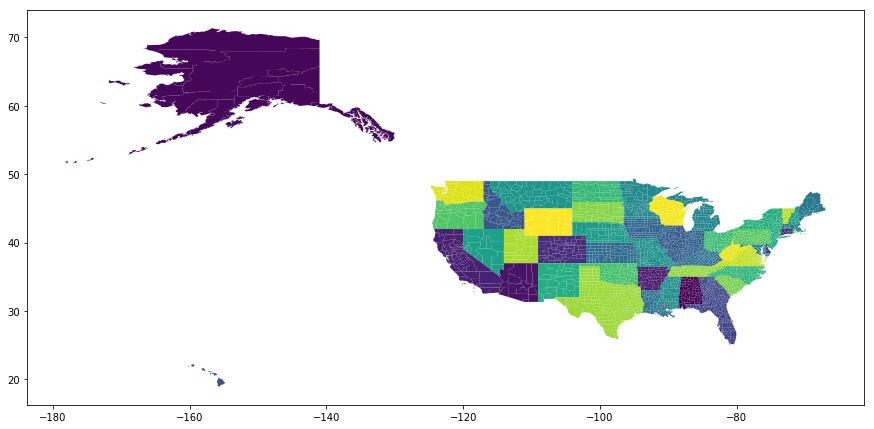

In [9]:
# County contours, with brighter colors tied to higher state codes
counties.plot(column='STATE_FIPS', figsize=(15,15));

In [ ]:
# Import a map of earthquake risk contour lines for the whole country.
quakes = geopandas.read_file('../data_input/stanford-rm034qp5477-geojson.json')

# The earthquake risk is a range of numbers, encoded as a string.  I'll
# turn that into a single float number that represents the center
# value of the range.  Anything marked '> 100' will get the value 110.

temp1 = quakes.percent_g.replace('> 100', '100 - 120')
range_limits = [x.split(' - ') for x in temp1]
range_averages = [(int(x[0]) + int(x[1]))/2 for x in range_limits]
quakes['pga'] = range_averages

# Drop useless columns
quakes = quakes.drop(columns=['id','percent_g','valley'])

In [ ]:
quakes.plot(facecolor='none', edgecolor='k', figsize=(15,15))

In [ ]:
# For each county, I'll produce a single risk number that represents 
# the whole county.  It is the average of all the risk zones that 
# intersect it.
# In the current version, I just note which regions intersect the county 
# regardless of their respective areas, and average out their risk values.

# Create a dataframe of intersections; one row gets generated
# for each risk contour that intersects the county.
intersections = geopandas.sjoin(counties, quakes, how="inner", 
                                op='intersects')

# The Geopandas dissolve function aggregates rows with the same value in a 
# given column, in this case the unique county code.
counties_avg_quake = intersections.dissolve(by='FIPS', aggfunc='mean')

# Once I have aggregate numbers for each county, I put them into a dictionary
avg_quake_dict = counties_avg_quake['pga'].to_dict()

# Apply the dictionary to each county in the original dataset.
counties['pga'] = counties['FIPS'].map(avg_quake_dict)

In [ ]:
print(counties.shape)
counties.head()

In [ ]:
# This is what the county-averaged risk looks for the whole country.
counties.plot(column='pga', figsize=(15,15));

In [ ]:
# And here's what it rooks like for California
counties[counties.STATE_NAME=='California'].plot(column='pga', figsize=(15,15));

In [ ]:
# I export it as a SHP file.
counties.to_file('Usable data/counties3')